In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("Fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

In [4]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

*From this previous step we can say that their is no missing or null values not present and also if we remove the outliers from the amount column could negatively impact the model's performance in detecting fraud*

In [5]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [6]:
# Encoding Categorical values using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

In [7]:
# Feature Engineering: Creating new features
data['balance_diff_orig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['balance_diff_dest'] = data['newbalanceDest'] - data['oldbalanceDest']


*By doing feature engineering step we can identify suspecious balance movement which is cruicial for identifying fraud*

In [8]:
# Define features and target variable
features = ['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
            'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest']

target = 'isFraud'

*The variables included in the model were selected based on their relevance to fraud detection*

In [11]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
# Training a Random Forest Classifier bacause it has many advantages such as RF not affected by multicolinearity, It’s robust 
# to overfitting, handles outliers well, and does not require extensive feature scaling also it will handles imbalanced dataset

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=80, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=80, random_state=42)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.83      0.89      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.91      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



In [14]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[1906287      64]
 [    415    2020]]
ROC-AUC Score: 0.9954


**Trying some another models to compare the peformance of this models**

In [15]:
import xgboost as xgb

# XGBoost Classifier
xgb_mod = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_mod.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_mod.predict(X_test)
y_prob_xgb = xgb_mod.predict_proba(X_test)[:, 1]

In [16]:
# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.86      0.91      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.93      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



In [17]:
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[1906254      97]
 [    334    2101]]


In [18]:
# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost ROC-AUC Score: {roc_auc_xgb:.4f}")

XGBoost ROC-AUC Score: 0.9992


In [19]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Normalizing the dataset using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Neural Network Model
nn_model = Sequential()

# Input Layer
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))

# Hidden Layer
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.5))

# Output Layer
nn_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
nn_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, verbose=1)

# Predictions
y_prob_nn = nn_model.predict(X_test)
y_pred_nn = (y_prob_nn > 0.5).astype(int)

Epoch 1/20
29825/29825 [==============================] - 45s 1ms/step - loss: 152.5521 - accuracy: 0.9954 - val_loss: 0.0096 - val_accuracy: 0.9987
Epoch 2/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.3940 - accuracy: 0.9987 - val_loss: 0.0101 - val_accuracy: 0.9987
Epoch 3/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.4993 - accuracy: 0.9986 - val_loss: 0.0099 - val_accuracy: 0.9987
Epoch 4/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.3668 - accuracy: 0.9986 - val_loss: 0.0100 - val_accuracy: 0.9987
Epoch 5/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.3145 - accuracy: 0.9986 - val_loss: 0.0099 - val_accuracy: 0.9987
Epoch 6/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.3217 - accuracy: 0.9986 - val_loss: 0.0101 - val_accuracy: 0.9987
Epoch 7/20
29825/29825 [==============================] - 44s 1ms/step - loss: 0.5783 - accuracy: 0.9986 - val_loss:

In [20]:
# Evaluation
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

Neural Network Classification Report:


C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.00      0.00      0.00      2045

    accuracy                           1.00   1590655
   macro avg       0.50      0.50      0.50   1590655
weighted avg       1.00      1.00      1.00   1590655



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

Neural Network Confusion Matrix:
[[1588610       0]
 [   2045       0]]


In [22]:
# ROC-AUC Score
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print(f"Neural Network ROC-AUC Score: {roc_auc_nn:.4f}")

Neural Network ROC-AUC Score: 0.5015


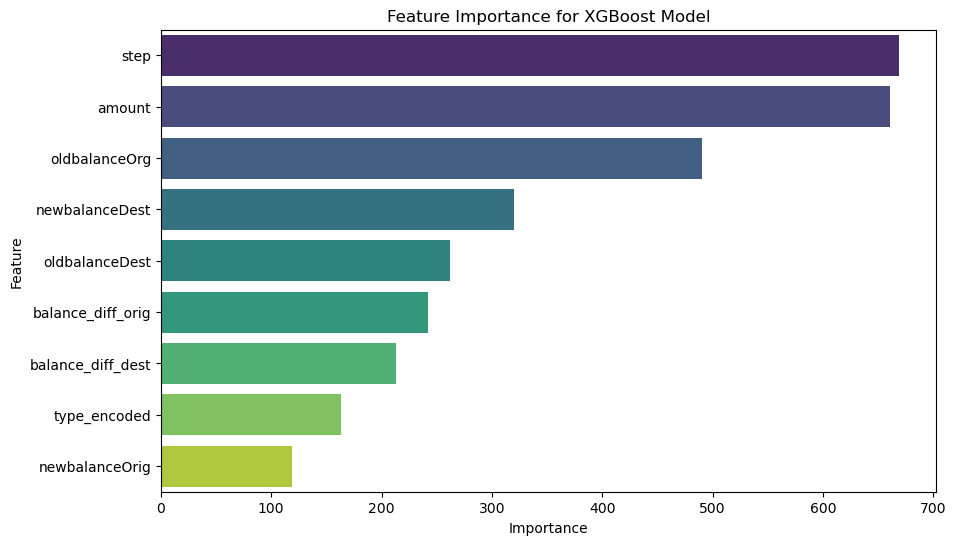

In [23]:
# After compairing these three models i have choose xgboost model 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importance from the trained XGBoost model
feature_importance = xgb_mod.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


*This feature importance demostrate the Key Factors That Predict Fraudulent Customer

These factors make sense because:
Transaction Amount: if large transactions occurs especially when unexpected, can indicate fraudulent activity.
Transaction Type: Fraudsters often aim to withdraw or transfer money quickly, hence these transaction types make sense as key indicators.
Balance Changes: Drastic balance changes often indicate unauthorized transactions where fraudsters attempt to withdraw funds rapidly.*

*For proactive fraud prevention, the company should implement following measures such as

real-time monitoring systems to monitor high-risk transactions and flag them for human review,two-factor Authentication to reduce unauthorized access, machine learning based alerts to detect abnormal behavior in real-time transactions and rate limiting-limit the number of transactions as per user.*

*To assess whether these prevention measures are working:

Fraud incident reduction: Track the number of fraud incidents before and after implementing the measures.
A decline in fraud cases would indicate success.
False positive rates: Monitor false positives. If the false positive rate decreases, it means the system is becoming more accurate.
Customer Feedback: Customer complaints about fraudulent activity should reduce after implementing stronger security.*